In [2]:
from pathlib import Path
import torch
import numpy as np
import py3Dmol
from rdkit import Chem
from constants import dataset_params
from tqdm import tqdm
from Bio.PDB import PDBParser

In [3]:
basedir = "/home/domainHomes/ssakharov/master_thesis/crossdocked"
train_set = torch.load(Path(basedir, 'split_by_name.pt'))["train"]
random_idx = np.random.randint(0, len(train_set))
random_example = train_set[random_idx]
print(random_example)
protein_file_rand = Path(basedir, "crossdocked_pocket10", random_example[0])
ligand_file_rand = Path(basedir, "crossdocked_pocket10", random_example[1])

('AMPC_ECOLI_20_377_0/4kzb_A_rec_4kz3_1u1_lig_tt_min_0_pocket10.pdb', 'AMPC_ECOLI_20_377_0/4kzb_A_rec_4kz3_1u1_lig_tt_min_0.sdf')


### Remove H atoms from ligands. (All ligand atoms are present in the atom_dict!!!) So nothing will be removed from a ligand

In [4]:
dataset_info = dataset_params['crossdock_full']
atom_dict = dataset_info['atom_encoder']
# for protein_file, ligand_file in tqdm(train_set):
#     try:
#         ligand = Chem.SDMolSupplier(str(Path(basedir, "crossdocked_pocket10", ligand_file)))[0]
#     except:
#         print("Could not load", ligand_file)
#         continue
#     lig_atoms_before = [a.GetSymbol() for a in ligand.GetAtoms()]
#     lig_atoms_after = [a.GetSymbol() for a in ligand.GetAtoms()
#                  if (a.GetSymbol().capitalize() in atom_dict or a.element != 'H')]
#     if len(lig_atoms_before) != len(lig_atoms_after):
#         print("Before:", lig_atoms_before)
#         print("After:", lig_atoms_after)
#         break

### Example of a ligand Atoms and how coordinates are stored:

In [5]:
ligand = Chem.SDMolSupplier(str(Path(basedir, "crossdocked_pocket10", ligand_file_rand)))[0]
lig_atoms = [a.GetSymbol() for a in ligand.GetAtoms()
                 if (a.GetSymbol().capitalize() in atom_dict or a.element != 'H')]
print(f"ligand atoms ", lig_atoms)
lig_coords = np.array([list(ligand.GetConformer(0).GetAtomPosition(idx))
                           for idx in range(ligand.GetNumAtoms())])
print(f"ligand coords (x,y,z) \n", lig_coords)

ligand atoms  ['C', 'C', 'C', 'S', 'C', 'Cl', 'S', 'O', 'O', 'N', 'C', 'O', 'O']
ligand coords (x,y,z) 
 [[-36.058   5.643   9.967]
 [-37.203   5.306   9.165]
 [-38.047   4.478   9.897]
 [-37.453   4.147  11.467]
 [-36.046   5.106  11.202]
 [-34.903   5.234  12.436]
 [-37.422   5.907   7.631]
 [-36.272   6.675   7.268]
 [-38.688   6.537   7.508]
 [-37.352   4.617   6.581]
 [-39.388   3.762   9.436]
 [-40.278   3.843  10.305]
 [-39.465   3.329   8.287]]


### Encode the ligand atoms to one-hot vectors

In [6]:
lig_one_hot = np.stack([
            np.eye(1, len(atom_dict), atom_dict[a.capitalize()]).squeeze()
            for a in lig_atoms
        ])
lig_one_hot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Check whether all residues are amino acids. Yes all residues in the dataset are amino acids

In [7]:
from Bio.PDB.Polypeptide import three_to_one, is_aa
not_aa = []
proteins_with_not_aa = []
# for protein_file, _ in tqdm(train_set):
#     protein = PDBParser(QUIET=True).get_structure("protein", str(Path(basedir, "crossdocked_pocket10", protein_file)))
#     try:
#         residues = protein[0].get_residues()
#     except:
#         print("Could not load", protein_file)
#         continue
#     for residue in residues:
#         if not is_aa(residue, standard=True):
#             not_aa.append(residue.get_resname())
#             proteins_with_not_aa.append(protein_file)

In [8]:
not_readable = "RDM1_ARATH_7_163_0/2q3t_A_rec_2q3t_cps_lig_tt_docked_262_pocket10.pdb"
protein = PDBParser(QUIET=True).get_structure("protein", str(Path(basedir, "crossdocked_pocket10", not_readable)))
len(protein)

0

### Visualize amino acids in a protein

In [9]:
pdb_struct = PDBParser(QUIET=True).get_structure('', protein_file_rand)

residues = set([residue.get_resname() for residue in pdb_struct[0].get_residues()])
chains = set([chain.get_id() for chain in pdb_struct[0].get_chains()])
print(f"{len(residues)} residues found: ",residues)
print(f"{len(chains)} chains found: ",chains)
for residue in pdb_struct[0].get_residues():
  atoms = [a for a in residue.get_atoms()]
  serials = [a.get_serial_number() for a in atoms]
  coords = np.array([a.get_coord() for a in atoms])
  print("Residue atoms: ", atoms)
  print("Serial numbers: ", serials)
  print("Corresponding coords (x,y,z): \n", coords)
  break


16 residues found:  {'LYS', 'VAL', 'PHE', 'HIS', 'TYR', 'ASN', 'SER', 'LEU', 'GLU', 'GLN', 'GLY', 'ARG', 'ALA', 'THR', 'ASP', 'PRO'}
1 chains found:  {'A'}
Residue atoms:  [<Atom N>, <Atom CA>, <Atom C>, <Atom O>]
Serial numbers:  [475, 476, 477, 478]
Corresponding coords (x,y,z): 
 [[-34.641  -1.629  14.805]
 [-34.447  -0.206  14.649]
 [-33.008   0.172  14.985]
 [-32.058  -0.513  14.616]]


In [10]:
from matplotlib import colors as mcolors
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(protein_file_rand, 'r').read(), 'pdb')

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
res_color_dict = {}
for res in residues:
    res_color_dict[res] = colors[np.random.randint(0, len(colors))]
    colors.remove(res_color_dict[res])
print(res_color_dict)
for residue in pdb_struct[0].get_residues():
    for atom in residue.get_atoms():
        view.setStyle({'model': -1, 'serial': atom.get_serial_number()}, {'stick': {'color': res_color_dict[residue.get_resname()]}})
view.zoomTo({'model': -1})

{'LYS': 'mediumorchid', 'VAL': 'darkturquoise', 'PHE': 'r', 'HIS': 'limegreen', 'TYR': 'fuchsia', 'ASN': 'yellow', 'SER': 'darkgrey', 'LEU': 'dimgray', 'GLU': 'hotpink', 'GLN': 'aqua', 'GLY': 'springgreen', 'ARG': 'seashell', 'ALA': 'lightsalmon', 'THR': 'chocolate', 'ASP': 'blue', 'PRO': 'darkslategrey'}


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Find interacting pocket residues based on distance cutoff
    1) Calculate distance between each ligand atom and each protein atom.
    2) Choose the smallest distance 
    3) If the smallest distance is less than the cutoff, then the ligand atom is interacting with the protein atom.

In [11]:
dist_cutoff=8
pocket_residues = []
for residue in pdb_struct[0].get_residues():
    res_coords = np.array([a.get_coord() for a in residue.get_atoms()])
    if is_aa(residue.get_resname(), standard=True) and \
            (((res_coords[:, None, :] - lig_coords[None, :, :]) ** 2).sum(
                -1) ** 0.5).min() < dist_cutoff:
        pocket_residues.append(residue)
pocket_residues_names = set([res.get_resname() for res in pocket_residues])
print(pocket_residues_names)
print(res_coords.shape)
print(lig_coords.shape)
print(res_coords[:, None, :].shape)
print(lig_coords[None, :, :].shape)
print(((res_coords[:, None, :] - lig_coords[None, :, :]) ** 2).shape)
print((((res_coords[:, None, :] - lig_coords[None, :, :]) ** 2).sum(-1) ** 0.5).shape)
print((((res_coords[:, None, :] - lig_coords[None, :, :]) ** 2).sum(-1) ** 0.5).min())

{'LYS', 'VAL', 'PHE', 'HIS', 'TYR', 'ASN', 'SER', 'LEU', 'GLU', 'GLN', 'GLY', 'ARG', 'ALA', 'THR', 'ASP', 'PRO'}
(4, 3)
(13, 3)
(4, 1, 3)
(1, 13, 3)
(4, 13, 3)
(4, 13)
9.49038348377852


In [12]:
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(protein_file_rand, 'r').read(), 'pdb')
view.addModelsAsFrames(open(ligand_file_rand, 'r').read())
view.setStyle({'model': -1}, {'stick': {'color': 'red'}})
for residue in pocket_residues:
    for atom in residue.get_atoms():
        view.setStyle({'model': 0, 'serial': atom.get_serial_number()}, {'stick': {'color': 'blue'}})
view.zoomTo({'model': 0})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
pocket_ids = [f'{res.parent.id}:{res.id[1]}' for res in pocket_residues]
### res.parent is a chain to which residue belongs
print(pocket_ids)

['A:63', 'A:64', 'A:119', 'A:120', 'A:121', 'A:152', 'A:211', 'A:212', 'A:213', 'A:214', 'A:215', 'A:217', 'A:220', 'A:221', 'A:222', 'A:318', 'A:319', 'A:320', 'A:123', 'A:61', 'A:209', 'A:321', 'A:322', 'A:317', 'A:343', 'A:67', 'A:150', 'A:122', 'A:204', 'A:210']


### Are all proteins monomers(consist of only one chain) in the dataset? No, there are some proteins that are not monomers

In [14]:
# chains_dict = {}
# for protein_file, _ in tqdm(train_set):
#     protein = PDBParser(QUIET=True).get_structure("protein", str(Path(basedir, "crossdocked_pocket10", protein_file)))
#     try:
#         chains = protein[0].get_chains()
#     except:
#         continue
#     chains = [chain for chain in chains]
#     if len(chains) not in chains_dict:
#         chains_dict[len(chains)] = [protein_file]
#     else:
#         chains_dict[len(chains)].append(protein_file)

In [15]:
# chain_length_dict = {}
# for chain_length in chains_dict:
#     chain_length_dict[chain_length] = len(chains_dict[chain_length])
# chain_length_dict

### How does the protein with 5 chains look like?

In [16]:
# print(chains_dict.keys())
# # print(chains_dict[5])
# view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
# path = Path(basedir, "crossdocked_pocket10", chains_dict[5][0])
# view.addModel(open(path, 'r').read(), 'pdb')
# view.setStyle({'model': -1}, {'cartoon': {}})
# colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
# chain_color_dict = {}
# protein = PDBParser(QUIET=True).get_structure("protein", str(Path(basedir, "crossdocked_pocket10", chains_dict[5][0])))
# for chain in protein.get_chains():
#     chain_color_dict[chain.get_id()] = colors[np.random.randint(0, len(colors))]
#     colors.remove(chain_color_dict[chain.get_id()])
# print(chain_color_dict)
# for chain in protein.get_chains():
#     # for residue in chain.get_residues():
#     for atom in chain.get_atoms():
#         view.setStyle({'model': -1, 'serial': atom.get_serial_number()}, {'stick': {'color': chain_color_dict[chain.get_id()]}})
# view.zoomTo({'model': -1})

### Protein embedding

#### ca_only: Each protein pocket is embedded as follows: 
    1) find only carbon alpha atoms in the pocket
    2) embedd each carbon alpha atom as a one-hot vector corresponding to its amino acid type and add it to a list
    3) save the coordinates of each carbon alpha atom in a list
    4) as output we have a list of one-hot vectors and a list of coordinates
#### as a result the model will only see the places where carbon alpha atoms are located and the information about the amino acid type in that place

In [17]:
pocket_one_hot = []
full_coords = []
dataset_info = dataset_params['crossdock']
amino_acid_dict = dataset_info['aa_encoder']
for res in pocket_residues:
    for atom in res.get_atoms():
        if atom.name == 'CA':
                        pocket_one_hot.append(np.eye(1, len(amino_acid_dict),
                                                     amino_acid_dict[three_to_one(res.get_resname())]).squeeze())
                        full_coords.append(atom.coord)
pocket_one_hot = np.stack(pocket_one_hot)
full_coords = np.stack(full_coords)
print(f"pocket shape: {pocket_one_hot.shape}")
print(f"full coords shape: {full_coords.shape}")
## find one hot encodings that repeat
unique, counts = np.unique(pocket_one_hot, axis=0, return_counts=True)
print(f"first unique one-hot vectors \n", unique[:2])
print(counts)

pocket shape: (30, 20)
full coords shape: (30, 3)
first unique one-hot vectors 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[2 3 1 2 1 1 2 2 1 1 1 6 1 1 2 3]


/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(


In [18]:
pocket_data = {
            'pocket_coords': full_coords,
            'pocket_one_hot': pocket_one_hot,
            'pocket_ids': pocket_ids
        }

### This means that we use only positions of alpha carbons to represent a protein. The CA atoms in a protein then look like this:

In [19]:
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
view.addModel(open(protein_file_rand, 'r').read(), 'pdb')
view.setStyle({'model': -1}, {'stick': {'color': 'red'}})
for residue in pocket_residues:
    for atom in residue.get_atoms():
        if atom.name == 'CA':
            view.setStyle({'model': -1, 'serial': atom.get_serial_number()}, {'stick': {'color': 'blue'}})
view.zoomTo({'model': -1})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### full model:

In [20]:
dataset_info = dataset_params['crossdock_full']
amino_acid_dict = dataset_info['aa_encoder']
pocket_one_hot = []
full_coords = []
full_atoms = np.concatenate(
    [np.array([atom.element for atom in res.get_atoms()])
        for res in pocket_residues], axis=0)
full_coords = np.concatenate(
    [np.array([atom.coord for atom in res.get_atoms()])
        for res in pocket_residues], axis=0)
print(f"full_coords.shape: {full_coords.shape}")
print(f"full_atoms.shape: {full_atoms.shape}")
print(full_atoms[:5])
print(full_coords[:5])

full_coords.shape: (213, 3)
full_atoms.shape: (213,)
['N' 'C' 'C' 'O' 'N']
[[-34.641  -1.629  14.805]
 [-34.447  -0.206  14.649]
 [-33.008   0.172  14.985]
 [-32.058  -0.513  14.616]
 [-32.844   1.262  15.708]]


### What is interesting that for the atom embedding the amino_acid_dict is used... (Does not make any difference since the atom_dict is the same as amino_acid_dict for crossdocked-full)

In [21]:
pocket_one_hot = []
for a in full_atoms:
    if a in amino_acid_dict:
        atom = np.eye(1, len(amino_acid_dict),
                        amino_acid_dict[a.capitalize()]).squeeze()
    elif a != 'H':
        atom = np.eye(1, len(amino_acid_dict),
                        len(amino_acid_dict)).squeeze()
    pocket_one_hot.append(atom)
pocket_one_hot = np.stack(pocket_one_hot)
print(f"pocket_one_hot.shape: {pocket_one_hot.shape}")
print(pocket_one_hot[:5])
pocket_data = {
            'pocket_coords': full_coords,
            'pocket_one_hot': pocket_one_hot,
            'pocket_ids': pocket_ids
        }

pocket_one_hot.shape: (213, 11)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### check whether all protein atoms in a dataset are in the atom_dict. Yes
### check wheter all atoms in the atom_dict are in the dataset. No
### So only {'C', 'H', 'N', 'O', 'S'} atoms are present in the protein dataset.

In [22]:
atoms = set()
# for protein_file, _ in tqdm(train_set):
#     protein = PDBParser(QUIET=True).get_structure("protein", str(Path(basedir, "crossdocked_pocket10", protein_file)))
#     try: 
#         residues = protein[0].get_residues()
#     except:
#         continue
#     for res in residues:
#         for atom in res.get_atoms():
#             atoms.add(atom.element)

In [23]:
atoms

set()

## Now statistics (for that already preprocessed dataset is used)

    Size of train.npz is 4.1GB for a full dataset and 1.1GB for a ca_only dataset

### Statistics for a full dataset

In [64]:
with np.load("/home/domainHomes/ssakharov/master_thesis/crossdocked/processed_crossdock_noH_full_temp/train.npz", allow_pickle=True) as data:
        lig_mask = data['lig_mask']
        pocket_mask = data['pocket_mask']
        lig_coords = data['lig_coords']
        lig_one_hot = data['lig_one_hot']
        pocket_one_hot = data['pocket_one_hot']

In [65]:
from scipy.ndimage import gaussian_filter
dataset_info = dataset_params['crossdock_full']

def get_n_nodes(lig_mask, pocket_mask, smooth_sigma=None):
    # Joint distribution of ligand's and pocket's number of nodes
    idx_lig, n_nodes_lig = np.unique(lig_mask, return_counts=True)
    idx_pocket, n_nodes_pocket = np.unique(pocket_mask, return_counts=True)

    assert np.all(idx_lig == idx_pocket)

    joint_histogram = np.zeros((np.max(n_nodes_lig) + 1,
                                np.max(n_nodes_pocket) + 1))

    for nlig, npocket in zip(n_nodes_lig, n_nodes_pocket):
        joint_histogram[nlig, npocket] += 1

    print(f'Original histogram: {np.count_nonzero(joint_histogram)}/'
          f'{joint_histogram.shape[0] * joint_histogram.shape[1]} bins filled')

    # Smooth the histogram
    if smooth_sigma is not None:
        filtered_histogram = gaussian_filter(
            joint_histogram, sigma=smooth_sigma, order=0, mode='constant',
            cval=0.0, truncate=4.0)

        print(f'Smoothed histogram: {np.count_nonzero(filtered_histogram)}/'
              f'{filtered_histogram.shape[0] * filtered_histogram.shape[1]} bins filled')

        joint_histogram = filtered_histogram

    return joint_histogram


In [66]:
n_nodes = get_n_nodes(lig_mask, pocket_mask, smooth_sigma=1.0)
n_nodes.shape

Original histogram: 14722/178797 bins filled
Smoothed histogram: 52407/178797 bins filled


(107, 1671)

Text(0.5, 1.0, 'Joint distribution of number of nodes in ligand and pocket')

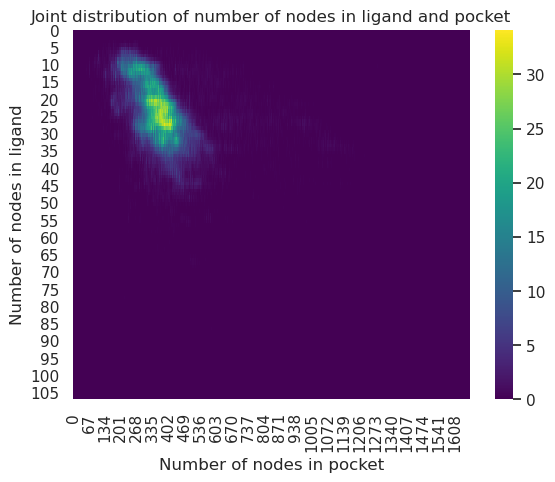

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(n_nodes, cmap='viridis')
plt.xlabel('Number of nodes in pocket')
plt.ylabel('Number of nodes in ligand')
plt.title('Joint distribution of number of nodes in ligand and pocket')

In [68]:
def get_type_histograms(lig_one_hot, pocket_one_hot, atom_encoder, aa_encoder):
    atom_decoder = list(atom_encoder.keys())
    atom_counts = {k: 0 for k in atom_encoder.keys()}
    for a in [atom_decoder[x] for x in lig_one_hot.argmax(1)]:
        atom_counts[a] += 1

    aa_decoder = list(aa_encoder.keys())
    aa_counts = {k: 0 for k in aa_encoder.keys()}
    for r in [aa_decoder[x] for x in pocket_one_hot.argmax(1)]:
        aa_counts[r] += 1

    return atom_counts, aa_counts

In [69]:
atom_hist, aa_hist = get_type_histograms(lig_one_hot, pocket_one_hot,
                                             atom_dict, amino_acid_dict)

/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWar

<Axes: >

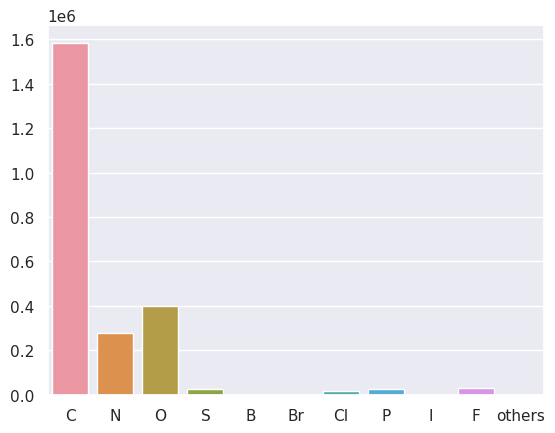

In [70]:
sns.barplot(x=list(atom_hist.keys()), y=list(atom_hist.values()))

/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/domainHomes/ssakharov/miniconda3/envs/thesis-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWar

<Axes: >

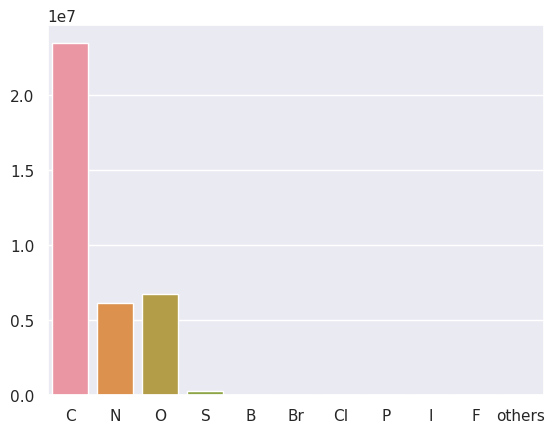

In [71]:
sns.barplot(x=list(aa_hist.keys()), y=list(aa_hist.values()))